# Joint flight data — first look

In [1]:
from setup   import *
from netCDF4 import Dataset
import glob

In [2]:
files = glob.glob("../data/*.nc")
halo_mw     = Dataset(glob.glob("../data/*nawd*mwr*.nc")[0],    "r")
halo_radar  = Dataset(glob.glob("../data/*nawd*cr*.nc")[0],     "r")
halo_sonde  = Dataset(glob.glob("../data/*nawd*sonde*.nc")[0],  "r")
rasta_radar = Dataset(glob.glob("../data/NAWDEX*RASTA*.nc")[0], "r")
faam_ismar  = Dataset(glob.glob("../data/metoffice-ismar_faam*.nc")[0], "r")
faam_marss  = Dataset(glob.glob("../data/metoffice-marss_faam*.nc")[0], "r")

### HAMP RADAR and passive data

For the HALO aircraft, the joined leg of the flight campaign lasted from 9:51 to 10:16 UTC. Here we extract the start and end time of the leg in seconds passed sind the reference data first of January 1970.

In [3]:
from datetime import datetime

t0 = datetime(year = 1970, month = 1, day = 1, hour = 0, minute = 0, second = 0)
t1 = datetime(year = 2016, month = 10, day = 14, hour = 9, minute = 51, second = 30)
t2 = datetime(year = 2016, month = 10, day = 14, hour = 10, minute = 15, second = 30)

dt_start = (t1 - t0).total_seconds()
dt_end   = (t2 - t0).total_seconds()

In [4]:
halo_times = halo_radar["time"][:]
i_start = np.where(halo_times >= dt_start)[0][0]
i_end   = np.where(halo_times >  dt_end)[0][0]

hamp_dbz = halo_radar["dbz"][i_start : i_end]
hamp_lat = halo_radar["lat"][i_start : i_end]
hamp_lon = halo_radar["lon"][i_start : i_end]
hamp_zsl = halo_radar["zsl"][i_start : i_end]
hamp_z   = halo_radar.variables["height"][:]
hamp_bt  = halo_mw.variables["tb"][i_start : i_end, :]
hamp_channels = np.array([1, 1, 1, 1, 1, 1, 1, 
                          2, 2, 2, 2, 2, 2, 2,
                          3,
                          4, 4, 4, 4,
                          5, 5, 5, 5, 5, 5, 5])

We define the coordinates of the first HAMP radar profile as reference coordinates. These will be used to convert the other coordinates to a rectilinear coordinate system within which the collocation will be performed.

In [5]:
lat_r = hamp_lat[0]
lon_r = hamp_lon[0]

In [6]:
from geopy import distance as dist
hamp_d = np.zeros(hamp_lat.shape)
for i in range(hamp_d.size):
    hamp_d[i] = dist.vincenty((lat_r, lon_r), (hamp_lat[i], hamp_lon[i])).km

### HALO Sondes


In [7]:
halo_sonde.variables['sonde_number'][:]
sonde_z   = halo_sonde.variables["height"][:]

sonde_lat_m = halo_sonde.variables["lat"][:]
sonde_lon_m = halo_sonde.variables["lon"][:]
sonde_p_m   = halo_sonde.variables["pa"][:]
sonde_rh_m  = halo_sonde.variables["hur"][:]
sonde_t_m  = halo_sonde.variables["ta"][:]
sonde_d_m = np.zeros(sonde_lat_m.shape)

sonde_lat = np.zeros(sonde_lat_m.shape)
sonde_lon = np.zeros(sonde_lat_m.shape)
sonde_p   = np.zeros(sonde_lat_m.shape)
sonde_t   = np.zeros(sonde_lat_m.shape)
sonde_rh  = np.zeros(sonde_lat_m.shape)
sonde_d   = np.zeros(sonde_lat_m.shape)

for i in range(sonde_lat.shape[0]):
    
    mask = sonde_lat_m.mask
    m = np.logical_not(mask[i, :])
    sonde_lat[i, :] = np.interp(sonde_z, sonde_z[m], sonde_lat_m[i, m])
    
    mask = sonde_lon_m.mask
    m = np.logical_not(mask[i, :])
    sonde_lon[i, :] = np.interp(sonde_z, sonde_z[m], sonde_lon_m[i, m])
    
    mask = sonde_p_m.mask
    m = np.logical_not(mask[i, :])
    sonde_p[i, :]   = np.interp(sonde_z, sonde_z[m], sonde_p_m[i, m])
    
    mask = sonde_t_m.mask
    m = np.logical_not(mask[i, :])
    sonde_t[i, :]   = np.interp(sonde_z, sonde_z[m], sonde_t_m[i, m])
    
    mask = sonde_rh_m.mask
    m = np.logical_not(mask[i, :])
    sonde_rh[i, :]  = np.interp(sonde_z, sonde_z[m], sonde_rh_m[i, m])
    
    
for i in range(sonde_d.shape[0]):
    for j in range(sonde_d[i, :].size):
        sonde_d[i, j] = dist.vincenty((lat_r, lon_r), (sonde_lat[i, j], sonde_lon[i, j])).km
        

for i in range(sonde_d.shape[0]):
    m = sonde_d[i, :] < 1000.0
    sonde_d[i, :]  = np.interp(sonde_z, sonde_z[m], sonde_d[i, m])
    
# Sort sondes

inds = np.argsort(sonde_d[:, 0])
sonde_d = sonde_d[inds, :]

In [8]:
sonde_lon[:, -1]

array([-8.2175312 , -8.79466724, -8.79401016, -7.80569887, -0.039262  ,
       -0.057904  , -1.97689104])

### Rasta data
For the Falcon aircraft, the time is given in hours since midnight so determining the start and end points of the joint flight is simpler.

In [9]:
rasta_radar.variables

OrderedDict([('range', <class 'netCDF4._netCDF4.Variable'>
              float32 range(range)
                  units: km
                  long_name: Range from the radar to the centre of each range gate
              unlimited dimensions: 
              current shape = (250,)
              filling on, default _FillValue of 9.969209968386869e+36 used),
             ('time', <class 'netCDF4._netCDF4.Variable'>
              float32 time(time)
                  units: hours UTC
                  long_name: Decimal hours UTC since midnight
                  missing_value: -999.0
              unlimited dimensions: time
              current shape = (11924,)
              filling on, default _FillValue of 9.969209968386869e+36 used),
             ('latitude', <class 'netCDF4._netCDF4.Variable'>
              float32 latitude(time)
                  units: degrees north
                  long_name: Latitude of the aircraft
                  missing_value: -999.0
                  comments:

In [10]:
from datetime import datetime

t_start = 9  + 50 / 60
t_end   = 10 + 21 / 60

In [11]:
rasta_times = rasta_radar["time"][:]
i_start = np.where(rasta_times >= t_start)[0][0]
i_end   = np.where(rasta_times >  t_end)[0][0]

rasta_dbz = rasta_radar["Z"][i_start : i_end, :]
rasta_lat = rasta_radar["latitude"][i_start : i_end]
rasta_lon = rasta_radar["longitude"][i_start : i_end]
altitude  = rasta_radar.variables["altitude"][i_start : i_end]
rasta_z   = rasta_radar.variables["height_2D"][i_start : i_end, :]
rasta_d = np.zeros(rasta_lat.shape)
for i in range(rasta_d.size):
    rasta_d[i] = dist.vincenty((lat_r, lon_r), (rasta_lat[i], rasta_lon[i])).km

## Ismar data

In [12]:
ismar_time = faam_ismar.variables["time"][:]
i_start = np.where(ismar_time / 3600 > 9.81)[0][0]
i_end   = np.where(ismar_time / 3600 >  10.35)[0][0]

ismar_angles  = faam_ismar.variables["angle"][i_start : i_end]
ismar_vangles = faam_ismar.variables["sensor_view_angle"][i_start : i_end]
indices = np.logical_and(ismar_vangles > -2, ismar_vangles < 2)
ismar_channel_names = ["".join([c.decode() for c in cs]) for cs in faam_ismar.variables["channel"]]
ismar_lat = faam_ismar.variables["latitude"][i_start : i_end][indices]
ismar_lon = faam_ismar.variables["longitude"][i_start : i_end][indices]
ismar_tbs = faam_ismar.variables["brightness_temperature"][i_start : i_end, :][indices]
ismar_azimuth = faam_ismar.variables["sensor_azimuth_angle"][i_start : i_end][indices]
ismar_pes = faam_ismar.variables["brightness_temperature_positive_error"][i_start : i_end, :][indices]
ismar_nes = faam_ismar.variables["brightness_temperature_negative_error"][i_start : i_end, :][indices]
ismar_channels = np.array([1, 1, 1, 1, 1, 2, 2, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 6, 6, 8, 8])
ismar_d = np.zeros(ismar_lat.shape)
for i in range(ismar_d.size):
    ismar_d[i] = dist.vincenty((lat_r, lon_r), (ismar_lat[i], ismar_lon[i])).km

### Channel selection

We ignore channels with excessively high variance (> 100)

In [13]:
#channels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 15, 16, 17, 18]
#len(np.where(np.all(np.logical_and(ismar_tbs[:, channels] > 0, ismar_tbs[:, channels] < 400), axis = 1))[0])

In [14]:
#ismar_tbs = ismar_tbs[:, channels]
#ismar_channels = ismar_channels[channels]

## MARSS

In [15]:
marss_time = faam_marss.variables["time"][:]
i_start = np.where(marss_time / 3600 > 9.81)[0][0]
i_end   = np.where(marss_time / 3600 >  10.35)[0][0]

marss_angles  = faam_marss.variables["angle"][i_start : i_end]
marss_vangles = faam_marss.variables["sensor_view_angle"][i_start : i_end]
indices = np.logical_and(marss_vangles > -3, marss_vangles < 3)
marss_lat = faam_marss.variables["latitude"][i_start : i_end][indices]
marss_lon = faam_marss.variables["longitude"][i_start : i_end][indices]
marss_tbs = faam_marss.variables["brightness_temperature"][i_start : i_end, :][indices]
marss_azimuth = faam_marss.variables["sensor_azimuth_angle"][i_start : i_end][indices]
marss_channels = np.array([1, 1, 1, 1, 1, 2, 2, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 6, 6, 8, 8])
marss_d = np.zeros(marss_lat.shape)
for i in range(marss_d.size):
    marss_d[i] = dist.vincenty((lat_r, lon_r), (marss_lat[i], marss_lon[i])).km

## DEM data

In [16]:
import rasterio
from scipy.interpolate import LinearNDInterpolator
dem_data = rasterio.open('../data/dem.tif')

west  = -6.9
south = 56.0
east  = -6.3
north = 60.0

dem_z = dem_data.read()[0, :, :]
height, width = dem_z.shape
dem_lon = np.linspace(west, east, width)
dem_lat = np.linspace(north, south, height)

## Flight path

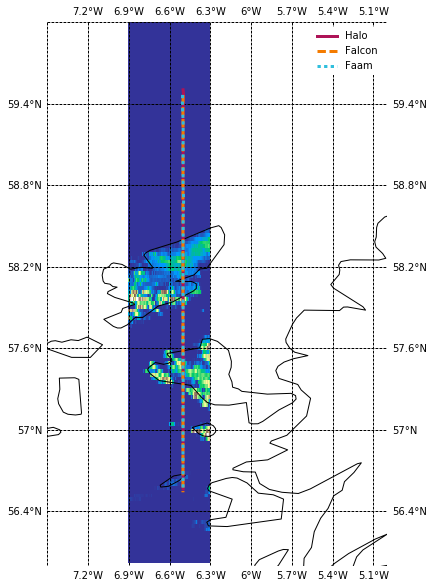

In [17]:
import cartopy.crs as ccrs
import matplotlib.ticker as mticker
from matplotlib.colors     import Normalize
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

fig = plt.figure(figsize = (10, 10))
ax  = fig.add_subplot(1, 1, 1, projection = ccrs.PlateCarree())

ax.plot(hamp_lon, hamp_lat, label = "Halo", lw = 3)
ax.plot(rasta_lon, rasta_lat, label = "Falcon", lw = 3, ls = "--")
ax.plot(ismar_lon, ismar_lat, lw = 3, ls = ":", label = "Faam")

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='black', linestyle='--')
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

ax.coastlines(resolution = "50m", linewidth = 1)

norm = Normalize(vmin = 0, vmax = 500)
ax.pcolormesh(dem_lon[::10], dem_lat[::100], dem_z[::100, ::10],
              norm = norm,
              cmap = "terrain")

ax.set_xlim([-7.5, -5])
ax.set_ylim([56, 60])
ax.legend()

fig.savefig("../plots/flight_path.png")

## Radar reflectivities

In [18]:
from scipy.interpolate import RegularGridInterpolator
f = RegularGridInterpolator((dem_lon, dem_lat[::-1]), dem_z.T[:, ::-1])
hamp_surf  = f((hamp_lon,  hamp_lat)) / 1000.0
rasta_surf = f((rasta_lon, rasta_lat)) / 1000.0

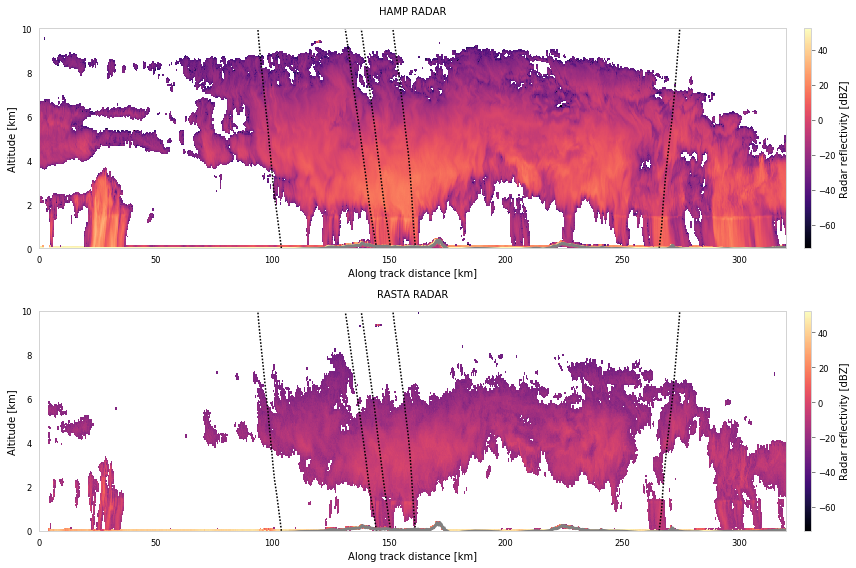

In [19]:
from matplotlib.gridspec import GridSpec

f  = plt.figure(figsize = (12, 8))
gs = GridSpec(2, 2, width_ratios = [1, 0.01])

ax = plt.subplot(gs[0, 0])
img = ax.pcolormesh(hamp_d, hamp_z[:] / 1e3, hamp_dbz.T)
f.colorbar(img, cax = plt.subplot(gs[0, 1]), label = "Radar reflectivity [dBZ]")
for i in range(sonde_d.shape[0]):
    ax.plot(sonde_d[i, :], sonde_z / 1e3, c = "k", ls = ":", label = "Radar reflectivity [dBZ]")
ax.set_title("HAMP RADAR")
ax.set_xlabel("Along track distance [km]")
ax.set_ylabel("Altitude [km]")
ax.set_ylim([0, 10])
ax.set_xlim([0, 320])
ax.plot(hamp_d.ravel(), hamp_surf.ravel(), c = "grey", lw = 3)

ax = plt.subplot(gs[1, 0])
ax.pcolormesh(np.broadcast_to(rasta_d.reshape(-1, 1), (rasta_z.shape)),
                rasta_z, rasta_dbz[:, :])
for i in range(sonde_d.shape[0]):
    ax.plot(sonde_d[i, :], sonde_z / 1e3, c = "k", ls = ":")
f.colorbar(img, cax = plt.subplot(gs[1, 1]), label = "Radar reflectivity [dBZ]")
ax.set_title("RASTA RADAR")
ax.set_xlabel("Along track distance [km]")
ax.set_ylabel("Altitude [km]")
ax.set_ylim([0, 10])
ax.set_xlim([0, 320])
ax.plot(rasta_d.ravel(), rasta_surf.ravel(), c = "grey", lw = 3)

plt.tight_layout()

fig.savefig("../plots/radar_reflectivities.png")

## HAMP brighness temperatures

(-16, 50)

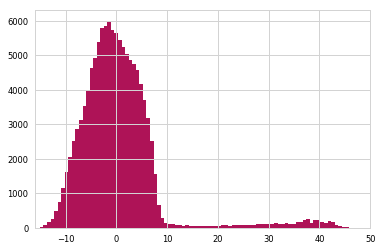

In [20]:
bins = np.linspace(-20, 50, 101)
plt.hist(rasta_dbz.ravel(), bins = bins)
plt.xlim([-16, 50])

In [21]:
from matplotlib.cm import Purples, Blues, Greens, Oranges, Reds, YlOrBr

cms = [Purples, Blues, Greens, Oranges, Reds]

In [22]:
list(map(len, channel_names))

NameError: name 'channel_names' is not defined

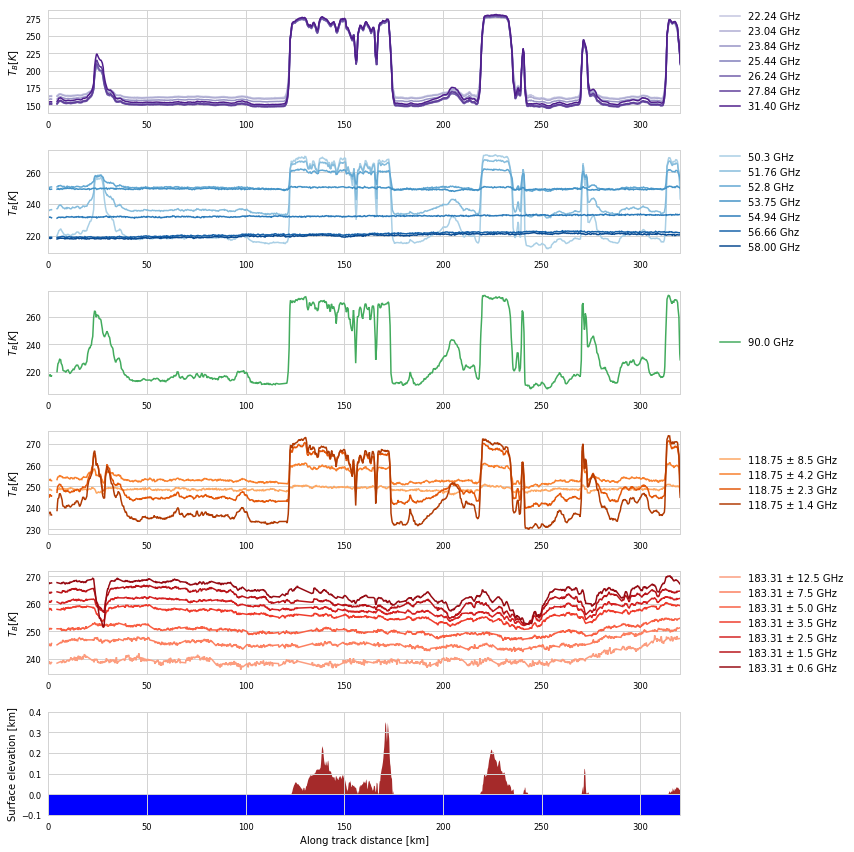

In [24]:
from matplotlib.gridspec import GridSpec

f  = plt.figure(figsize = (12, 12))
gs = GridSpec(6, 1, width_ratios = [1])

channel_names_hamp = [["22.24 GHz", "23.04 GHz", "23.84 GHz", "25.44 GHz",   \
                   "26.24 GHz", "27.84 GHz", "31.40 GHz"],               \
                  ["50.3 GHz", "51.76 GHz", "52.8 GHz", "53.75 GHz", "54.94 GHz", \
                   "56.66 Ghz", "58.00 GHz"],
                  ["90.0 GHz"],
                  ["118.75 ± 8.5 GHz", "118.75 ± 4.2 GHz", "118.75 ± 2.3 GHz", \
                   "118.75 ± 1.4 GHz"], 
                  ["183.31 ± 12.5 GHz", "183.31 ± 7.5 GHz", "183.31 ± 5.0 GHz", \
                   "183.31 ± 3.5 GHz", "183.31 ± 2.5 GHz", "183.31 ± 1.5 GHz",  \
                   "183.31 ± 0.6 GHz"]]

for i in range(5):
    
    cm = cms[i]
    ncs = len([c for c in hamp_channels if c == i + 1])
    cs = [cm(64 + i * 191 // (ncs + 1)) for i in range(ncs + 1)][1:]
    
    ax = plt.subplot(gs[i, 0])
    
    ci = 0
    for j, c in enumerate(hamp_channels):
        if i + 1 == c:
            ax.plot(hamp_d, hamp_bt[:, j], c = cs[ci], label = channel_names_hamp[i][ci])
            ci += 1
            
    ax.set_xlim([0, 320])
    ax.set_ylabel("$T_B [K]$")
    
    ax.legend(loc = "center left", bbox_to_anchor = [1.05, 0.5], ncol = 1)
            
ax = plt.subplot(gs[5, 0])
ax.fill_between(hamp_d, y1 = hamp_surf, y2 = 0.0,  color = "brown")
ax.fill_between(hamp_d, y1 = 0, y2 = -10,  color = "blue")
ax.set_ylim([-0.1, 0.4])
ax.set_xlim([0, 320])
ax.set_xlabel("Along track distance [km]")
ax.set_ylabel("Surface elevation [km]")


plt.tight_layout()

f.savefig("../plots/hamp_passive.png", bbox_inches = "tight")

## ISMAR brightness temperatures

In [25]:
cms = [Purples, Blues, Greens, Oranges, Reds, YlOrBr]

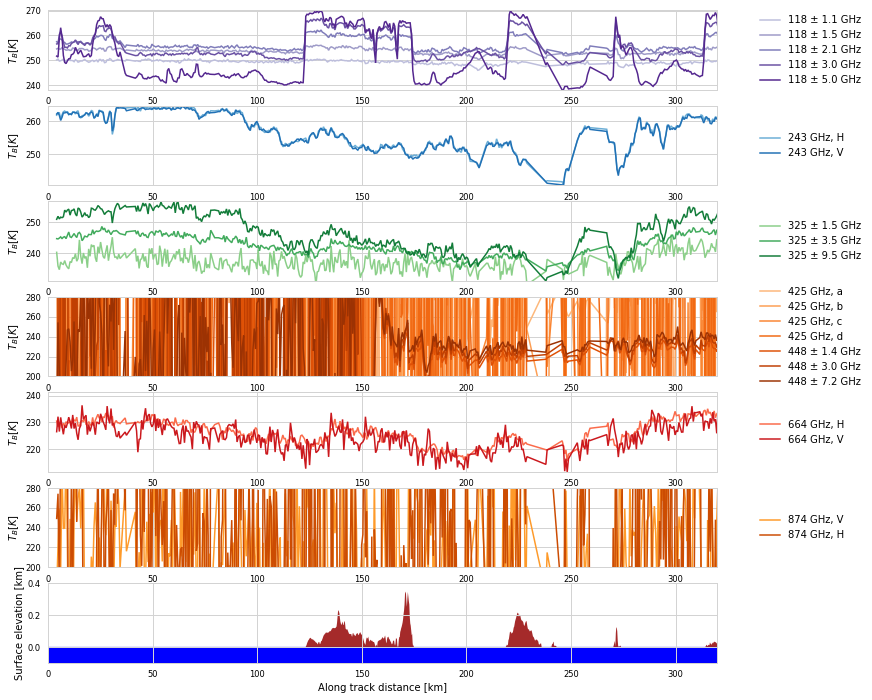

In [26]:
from matplotlib.gridspec import GridSpec

f  = plt.figure(figsize = (12, 12))
gs = GridSpec(7, 1, width_ratios = [1])

channel_names_ismar = [["118 ± 1.1 GHz", "118 ± 1.5 GHz", "118 ± 2.1 GHz", "118 ± 3.0 GHz", "118 ± 5.0 GHz"],
                 ["243 GHz, H", "243 GHz, V"],
                 ["325 ± 1.5 GHz", "325 ± 3.5 GHz", "325 ± 9.5 GHz"],
                 ["425 GHz, a", "425 GHz, b", "425 GHz, c", "425 GHz, d", "448 ± 1.4 GHz", "448 ± 3.0 GHz", "448 ± 7.2 GHz"],
                 ["664 GHz, H", "664 GHz, V"],
                 ["874 GHz, V", "874 GHz, H"]]

for i, j in enumerate(set(ismar_channels)):
    cm = cms[i]
    ncs = len([c for c in ismar_channels if c == j])
    cs = [cm(64 + i * 191 // (ncs + 1)) for i in range(ncs + 1)][1:]
    
    ax = plt.subplot(gs[i, 0])
    
    ci = 0
    y_min = 300.0
    y_max = 280.0
    for k, c in enumerate(ismar_channels):
        if j == c:
            ax.plot(ismar_d, ismar_tbs[:, k], c = cs[ci], label = channel_names_ismar[i][ci])
            ci += 1
            
            y_max = min(280.0, ismar_tbs[:, k].max())
            y_min = max(200.0, ismar_tbs[:, k].min())
            
    ax.set_xlim([0, 320])
    
    ax.set_ylim([y_min, y_max])
    ax.set_ylabel("$T_B [K]$")
    
    ax.legend(loc = "center left", bbox_to_anchor = [1.05, 0.5], ncol = 1)
            
ax = plt.subplot(gs[6, 0])
ax.fill_between(hamp_d, y1 = hamp_surf, y2 = 0.0,  color = "brown")
ax.fill_between(hamp_d, y1 = 0, y2 = -10,  color = "blue")
ax.set_ylim([-0.1, 0.4])
ax.set_xlim([0, 320])
ax.set_xlabel("Along track distance [km]")
ax.set_ylabel("Surface elevation [km]")

f.savefig("../plots/ismar_passive.png", bbox_inches = "tight")

/home/simon/src/matplotlib/lib/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/simon/src/matplotlib/lib/matplotlib/figure.py:2052: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


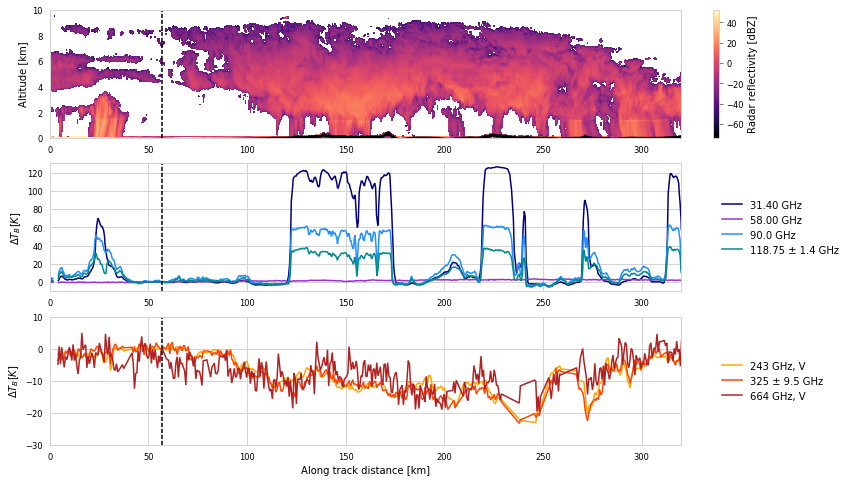

In [72]:
from matplotlib.gridspec import GridSpec

f  = plt.figure(figsize = (12, 8))
gs = GridSpec(3, 2, width_ratios = [1, 0.01], wspace = 0.1)

cs = ["navy", "darkorchid", "dodgerblue", "darkcyan", 
      "orange", "orangered", "firebrick"]

csd = 57
csi = np.where(hamp_d > csd)[0][0]

ax = plt.subplot(gs[0, 0])
img = ax.pcolormesh(hamp_d, hamp_z[:] / 1e3, hamp_dbz.T)
f.colorbar(img, cax = plt.subplot(gs[0, 1]), label = "Radar reflectivity [dBZ]")
ax.axvline(x = hamp_d[csi], c = "k", ls = "--")
ax.set_ylabel("Altitude [km]")
ax.set_ylim([0, 10])
ax.set_xlim([0, 320])
ax.plot(hamp_d.ravel(), hamp_surf.ravel(), c = "k", lw = 3)

ax = plt.subplot(gs[1, 0])

ci = 0
channel_names = []
for n in channel_names_hamp:
    channel_names += n
    
handles = []
labels  = []

for j, i in enumerate(np.where(np.diff(hamp_channels))[0]):
    
    ax = plt.subplot(gs[1, 0])
    mn = hamp_bt[csi, i]
    handles += ax.plot(hamp_d, hamp_bt[:, i] - mn, c = cs[ci], label = channel_names[i])
    labels  += [channel_names[i]]
    ci += 1
    ax.set_xlim([0, 320])
    ax.set_ylim([-10, 130])
    ax.set_ylabel("$\Delta T_B [K]$")
    
ax.axvline(x = hamp_d[csi], c = "k", ls = "--")
ax = plt.subplot(gs[1, 1])
ax.legend(handles = handles, labels = labels, loc = "center left")
ax.set_axis_off()
            
channel_names = []
for n in channel_names_ismar:
    channel_names += n

ax = plt.subplot(gs[2, 0])
csi = np.where(ismar_d > csd)[0][0]
    
handles = []
labels  = []

for i, j in enumerate([6, 9, 18]):
    first = True
    
    y_min = 300.0
    y_max = 280.0
    
    mn = ismar_tbs[csi, j]
    handles += ax.plot(ismar_d, ismar_tbs[:, j] - mn, c = cs[ci], label = channel_names[j])
    labels  += [channel_names[j]]
    ci += 1
            
    ax.set_xlim([0, 320])
    ax.set_ylim([-30, 10])
    ax.set_ylabel("$\Delta T_B [K]$")
    
ax.axvline(x = ismar_d[csi], c = "k", ls = "--")
ax.set_xlabel("Along track distance [km]")

ax = plt.subplot(gs[2, 1])
ax.legend(handles = handles, labels = labels, loc = "center left")
ax.set_axis_off()

plt.tight_layout()
f.savefig("../plots/ici_frequencies.png", bbox_inches = "tight")

## Era 5 Data

In [25]:
era_5.close()

NameError: name 'era_5' is not defined

In [ ]:
era_5.variables

In [ ]:
from netCDF4 import Dataset

era_5      = Dataset("../data/era_5_surface.nc", "r")
era_5_lon  = era_5.variables["longitude"][:]
era_5_lat  = era_5.variables["latitude"][:]
era_5_u_10 = era_5.variables["u10"][:]
era_5_v_10 = era_5.variables["v10"][:]
era_5_sst  = era_5.variables["sst"][:]
era_5_skt  = era_5.variables["skt"][:]

In [ ]:
f = RegularGridInterpolator((era_5_lon, era_5_lat[::-1]), era_5_u_10[0, ::-1, :].T)
hamp_u_10 = f((hamp_lon + 360.0, hamp_lat))

f = RegularGridInterpolator((era_5_lon, era_5_lat[::-1]), era_5_v_10[0, ::-1, :].T)
hamp_v_10 = f((hamp_lon + 360.0, hamp_lat))

f = RegularGridInterpolator((era_5_lon, era_5_lat[::-1]), era_5_sst[0, ::-1, :].T)
hamp_sst = f((hamp_lon + 360.0, hamp_lat))

f = RegularGridInterpolator((era_5_lon, era_5_lat[::-1]), era_5_skt[0, ::-1, :].T)
hamp_skt = f((hamp_lon + 360.0, hamp_lat))

In [ ]:
from netCDF4 import Dataset

era_5      = Dataset("../data/era_5.nc", "r")
era_5_lon  = era_5.variables["longitude"][:]
era_5_lat  = era_5.variables["latitude"][:]
era_5_z    = era_5.variables["z"][:]
era_5_p   = np.array(['1','2','3', '5','7','10', '20','30','50',
                      '70','100','125', '150','175','200', '225',
                      '250','300', '350','400','450', '500','550',
                      '600', '650','700','750', '775','800','825',
                      '850','875','900', '925','950','975', '1000'], dtype = np.float64)

f = RegularGridInterpolator((era_5_p, era_5_lat[::-1], era_5_lon), era_5_z[0, :, ::-1, :])

In [ ]:
p = np.linspace(1000, sonde_p.min(), 501)
pp, lat = np.meshgrid(p, hamp_lat)
pp, lon = np.meshgrid(p, hamp_lon)
z_interp = f((pp, lat, lon + 360))

## Retrieval data

We need to ensure that the pressure grid is decreasing.

In [ ]:
ds.close()

In [ ]:
from netCDF4 import Dataset
ds = Dataset("../data/input.nc", "w")

In [ ]:
z_ss  = 5
z_ind = np.where(hamp_z > 12e3)[0][0]

In [ ]:
profile_index = ds.createDimension("profile_index", hamp_d.size)
altitude      = ds.createDimension("altitude", hamp_z[:z_ind:z_ss].size)

ds.createVariable("sea_surface_temperature", "f8", dimensions = ("profile_index",))
ds.createVariable("surface_temperature", "f8", dimensions = ("profile_index",))
ds.createVariable("wind_u", "f8", dimensions = ("profile_index",))
ds.createVariable("wind_v", "f8", dimensions = ("profile_index",))
ds.createVariable("pressure", "f8", dimensions = ("profile_index", "altitude"))
ds.createVariable("humidity", "f8", dimensions = ("profile_index", "altitude"))
ds.createVariable("H2O", "f8", dimensions = ("profile_index", "altitude"))
ds.createVariable("temperature", "f8", dimensions = ("profile_index", "altitude"))

In [ ]:
ds.variables["sea_surface_temperature"][:] = hamp_sst
ds.variables["surface_temperature"][:] = hamp_skt
ds.variables["wind_u"][:] = hamp_u_10
ds.variables["wind_v"][:] = hamp_v_10

In [ ]:
ds.createVariable("altitude", "f8", ("profile_index", "altitude"))
ds.variables["altitude"][:] = np.broadcast_to(hamp_z.reshape(1, -1), hamp_dbz.shape)[:, :z_ind:z_ss]

In [ ]:
from typhon.physics.atmosphere import relative_humidity2vmr

pressure = np.zeros((hamp_d.size, hamp_z.size))
humidity = np.zeros((hamp_d.size, hamp_z.size))
temperature = np.zeros((hamp_d.size, hamp_z.size))
altitude = np.broadcast_to(hamp_z.reshape(1, -1), pressure.shape)

#for i in range(hamp_z.size):
pressure[:, :] = 100 * sonde_p[3, :] #np.interp(hamp_d, sonde_d[:, i], sonde_p[:, i])
humidity[:, :] = sonde_rh[3, :] / 100 #np.interp(hamp_d, sonde_d[:, i], sonde_rh[:, i])
temperature[:, :] = sonde_t[3, :] #np.interp(hamp_d, sonde_d[:, i], sonde_t[:, i])

dp = np.diff(pressure, axis = 1)
for i in range(dp.shape[1]):
    if np.any(dp[:, i] == 0):
        pressure[:, i] -= 0.5 * dp[:, i - 1]
        pressure[:, i + 1] += 0.5 * dp[:, i - 1]
    
ds.variables["pressure"][:, :] = pressure[:, :z_ind:z_ss]
ds.variables["humidity"][:, :] = humidity[:, :z_ind:z_ss]
ds.variables["H2O"][:, :] = relative_humidity2vmr(humidity, pressure, temperature)[:, :z_ind:z_ss]
ds.variables["temperature"][:, :] = temperature[:, :z_ind:z_ss]

In [ ]:
ds.createVariable("O2", "f8", dimensions = ("profile_index", "altitude"))
ds.createVariable("O3", "f8", dimensions = ("profile_index", "altitude"))
ds.createVariable("N2", "f8", dimensions = ("profile_index", "altitude"))

In [ ]:
z_b = np.array([119.26605505,  2118.57516973,   4027.60345297,   5862.87711004,
             7627.64498975,  9297.02869728,  10892.59889357,  12434.63769365,
             13904.25695207, 15290.83137241,  16635.83815029,  17963.99841403,
             19346.95698534, 20750.73842791,  22184.62422791,  23675.44467966,
             25180.02964216, 26780.47609985,  28320.01292605,  29820.7853969 ,
             31494.56521739])
o2  = np.array([ 0.20914768,  0.20917247,  0.20911265,  0.20919441,  0.20921843,
              0.20915963,  0.20914215,  0.20918673,  0.20921144,  0.20916823,
              0.20915074,  0.20918311,  0.20910791,  0.20914558,  0.20908499,
              0.20913025,  0.20910134,  0.20907593,  0.20910521,  0.2091797 ,
              0.20917443])
o2 = np.interp(hamp_z, z_b, o2)
ds.variables["O2"][:, :] = np.broadcast_to(o2.reshape(1, -1), hamp_dbz.shape)[:, :z_ind:z_ss]

o3  = np.array([2.90479819e-08,   3.36389220e-08,   3.56864241e-08,
                3.96190027e-08,   4.38274934e-08,   5.18099738e-08,
                6.50830255e-08,   8.46137019e-08,   1.03927382e-07,
                1.31159885e-07,   2.11682715e-07,   4.91257992e-07,
                1.10672315e-06,   1.70139678e-06,   2.58579126e-06,
                4.01127013e-06,   5.57665027e-06,   7.11467740e-06,
                8.29916685e-06,   9.20149730e-06,   9.63690492e-06])
o3 = np.interp(hamp_z, z_b, o3)
ds.variables["O3"][:, :] = np.broadcast_to(o3.reshape(1, -1), hamp_dbz.shape)[:, :z_ind:z_ss]

n2 = np.array([0.78143085,  0.78164177,  0.78123672,  0.78189026,  0.78169185,
               0.78155673,  0.78151964,  0.78156695,  0.78156223,  0.78157601,
               0.78164542,  0.78170006,  0.78154427,  0.78127151,  0.78165497,
               0.78161547,  0.7815775 ,  0.78152597,  0.78153412,  0.78159145,
               0.78158467])
n2 = np.interp(hamp_z, z_b, n2)
ds.variables["N2"][:, :] = np.broadcast_to(n2.reshape(1, -1), hamp_dbz.shape)[:, :z_ind:z_ss]


### Hamp radar

In [ ]:
y = np.maximum(hamp_dbz.data, -30)
dz = hamp_z - np.maximum(hamp_surf.reshape(-1, 1) * 1000, 0.0)
y[dz < 250] = -30
#plt.pcolor(y.T)

In [ ]:
ds.createVariable("y_hamp_radar", "f8", dimensions = ("profile_index", "altitude"))
ds.variables["y_hamp_radar"][:, :] = y[:, :z_ind:z_ss]

### Hamp radiometer

In [ ]:
ds.createDimension("hamp_channels", size = 26)
ds.createVariable("y_hamp_passive", "f8", dimensions = ("profile_index", "hamp_channels"))

In [ ]:
hamp_bt[22, :]

In [ ]:
ds.variables["y_hamp_passive"][:, :] = hamp_bt

## Rasta radar

In [ ]:
y_rasta = -16 * np.ones(rasta_dbz.shape)
inds    = np.logical_not(rasta_dbz.mask)
y_rasta[inds] = np.maximum(rasta_dbz[inds], -16)
for i in range(rasta_dbz.shape[0]):
    inds = 0.2 > rasta_z[i, :] - np.maximum(rasta_surf[i], 0.0)
    y_rasta[i, inds] = -16
y_rasta[:, 200:] = -16

In [ ]:
def center_to_edges(z):
    range_bins = np.zeros(z.size + 1)
    range_bins[1:-1] = 0.5 * (z[1:] + z[:-1])
    range_bins[0]  = 2 * range_bins[1] - range_bins[2]
    range_bins[-1] = 2 * z[-1] - z[-2]
    return range_bins

In [ ]:
rasta_range_bins = np.zeros((rasta_z.shape[0], rasta_z.shape[1] + 1))
for i in range(rasta_z.shape[0]):
    rasta_range_bins[i, :] = center_to_edges(rasta_z[i, :])
    
y_rasta_i = np.zeros((hamp_d.size, rasta_z.shape[1]))
rasta_range_bins_i = np.zeros((hamp_d.size, z.shape[1] + 1))
for i in range(rasta_z.shape[1]):
    y_rasta_i[:, i]    = np.interp(hamp_d, rasta_d, y_rasta[:, i])
    rasta_range_bins_i[:, i] = np.interp(hamp_d, rasta_d, rasta_range_bins[:, i])

In [ ]:
ds.createDimension("rasta_range_bins", y_rasta_i[:, ::z_ss].shape[1] + 1)
ds.createVariable("rasta_range_bins", "f8", ("profile_index", "rasta_range_bins",))
ds.variables["rasta_range_bins"][:, :] = rasta_range_bins_i[:, ::z_ss]

In [ ]:
y_rasta.shape

In [ ]:
rasta_range_bins_i.shape

In [ ]:
y_rasta_i.shape

In [ ]:
#ds.createDimension("rasta_gates", y_rasta_i[:, ::z_ss].shape[1])
#ds.createVariable("y_rasta", "f8", dimensions = ("profile_index", "rasta_gates"))
ds.variables["y_rasta"][:, :] = y_rasta_i[:, ::z_ss]

### ISMAR radiometer

In [ ]:
ds.createDimension("ismar_channels", size = 21)
ds.createVariable("y_ismar", "f8", dimensions = ("profile_index", "ismar_channels"))

In [ ]:
y_ismar = np.zeros((hamp_d.size, 21))
for i in range(21):
    ds.variables["y_ismar"][:, i] = np.interp(hamp_d, ismar_d, ismar_tbs[:, i])

In [ ]:
ds.close()

In [ ]:
humidity

In [ ]:
ds.variables["pressure"]

In [ ]:
dp.shape

In [ ]:
dp = np.diff(pressure, axis = 1)
for i in range(dp.shape[1]):
    if np.any(dp[:, i] == 0):
        print(i)
        pressure[:, i] -= 0.5 * dp[:, i - 1]
        pressure[:, i + 1] += 0.5 * dp[:, i - 1]

In [ ]:
plt.matshow(dp == 0.0)
plt.grid("off")

In [ ]:
dp[10] == 0.0